<font size="5">Customer Analysis</font><br>

There are many problems business has to overcome to achieve its goals.<br>
Some of them are customer related.<br>
How to reach them? What to recommend them?<br>
And probably the most important, how to make it effectively?<br>
Marketing costs a lot of money and time, offering the wrong product to the wrong people on the wrong time<br>
can be not only wastefull but also cause some damage if customers lose trust and makes negative impression<br>
about the company in general.<br>
<br>
In this example we will try to build a model, which analysis customers and tries to reveal their potential, so<br>
the marketing team could build more effective marketing campaigns.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import tensorflow as tf
from keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import joblib

Firstly, we will load the data and rename some columns with more friendly names.<br>
(There is a description file in the folder alongside .csv)

In [9]:
data = pd.read_csv('marketing_campaign.csv', sep = '\t')
data = data.drop_duplicates()
data = data.dropna()
data.rename(columns = {'NumWebPurchases':'Web', 'NumCatalogPurchases':'Catalogue', 'NumStorePurchases':'Store','MntWines':'Wines', 'Dt_Customer':'Customer_tenure',
                       'MntFruits':'Fruits', 'MntMeatProducts':'Meat', 'MntFishProducts':'Fish', 'MntSweetProducts':'Sweet', 'MntGoldProds':'Gold'}, inplace=True)

Now we will check if it is historical data containing customer history, or just general information about them

In [10]:
print('Total unique customers IDs:', len(data.apply(np.unique, axis = 0)['ID']))
print('Total data points:', len(data))

Total unique customers IDs: 2216
Total data points: 2216


Unique IDs and total data points count is the same, indicating that data contains general information about the customers.<br>
<br>
Now lets dive in to the features.
Some of the features are categorical, and we need to convert to numerical.<br>
Some features are dates, we need to convert them to numerically interpretable forms<br>
for example, date of birth should be converted to age.<br>
Also, we need to check if data is valid and clean if needed.

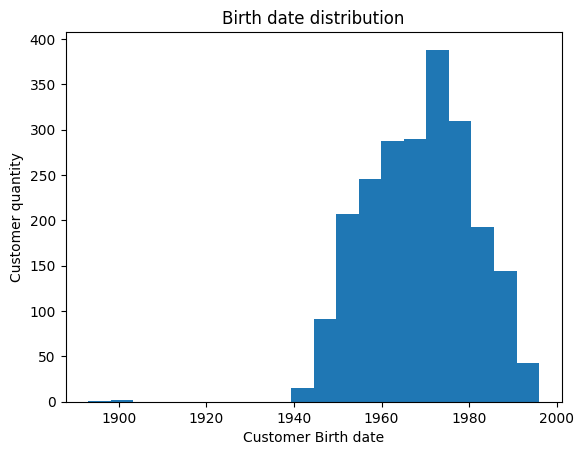

In [11]:
plt.hist(data['Year_Birth'], bins = 20)
plt.title('Birth date distribution')
plt.ylabel('Customer quantity')
plt.xlabel('Customer Birth date')
plt.show()

Dates look normaly distributed, except for those around 1900 year.<br>
I don't think that these customers are over a 100 years old. Even though they were, they do not represent clear group<br>
and act more like an outliers.

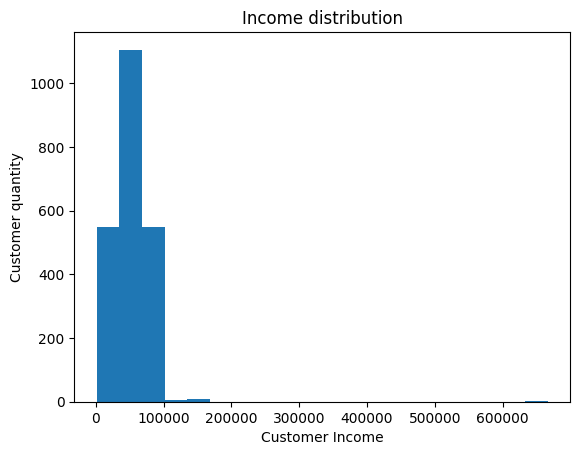

In [12]:
plt.hist(data['Income'], bins = 20)
plt.title('Income distribution')
plt.ylabel('Customer quantity')
plt.xlabel('Customer Income')
plt.show()

We see similar situation with income. Most values are between 0 and 100000, but one is over 600000.<br>
For the same reason as before we will treat it as an outlier.<br>

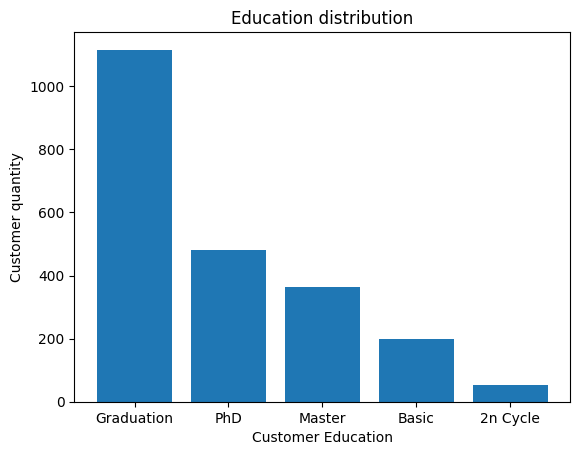

In [13]:
plt.bar(data['Education'].unique(), data['Education'].value_counts().values)
plt.title('Education distribution')
plt.ylabel('Customer quantity')
plt.xlabel('Customer Education')
plt.show()

We can see that most customers has higher education, there is also '2n Cycle' value, which is equivalent<br>
to 'Master' so I will just merge them. Also, we need to convert data to numerical.

In [14]:
data['Education'] = data['Education'].replace('2n Cycle', 'Master')
data['Education'] = data['Education'].map({'Basic': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4})

In [15]:
# Also we need to convert date of birth to actual age.
data['Age'] = 2024-data['Year_Birth']
data = data[data['Age'] < 100]

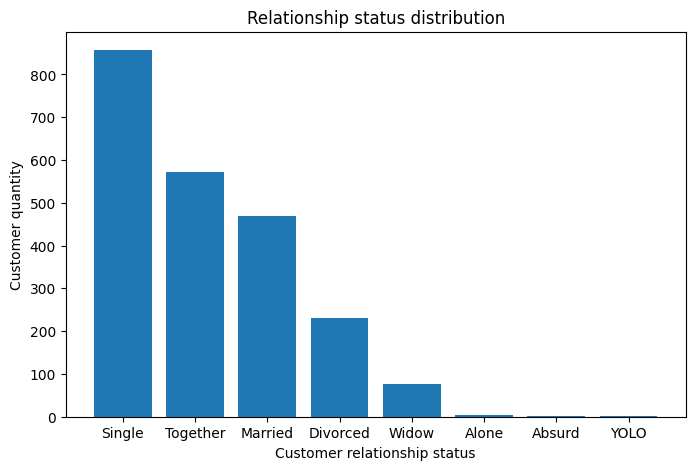

In [16]:
# Also, we have marital status.
plt.figure(figsize=(8, 5))
plt.bar(data['Marital_Status'].unique(), data['Marital_Status'].value_counts().values)
plt.title('Relationship status distribution')
plt.ylabel('Customer quantity')
plt.xlabel('Customer relationship status')
plt.show()

As we can see, we also have some incorrect data. 'Absurd', 'YOLO'. Also, 'Alone' is not very clear, might be single might be divorced.<br>
As there is not that much of them, I will just remove it together with incorrect ones.

In [17]:
data['Marital_Status'] = data['Marital_Status'].apply(lambda x: 0 if x in ['Alone', 'Absurd', 'YOLO'] else x)
data = data[data['Marital_Status'] != 0]

Beside that, we need to convert them to numeric values, but<br>
features does not have clear hierarchical structure. For example, together and married can be living together so might fall into the same group.<br>
Divorced and widowed are also single, so you might just categorize, single or not.<br>
But there might be hidden psychological information like customer value system and lifestyle.<br>
So, I prefer one hot encoding.

In [18]:
encoder = OneHotEncoder(sparse_output=False)
marital_status = encoder.fit_transform(data[['Marital_Status']])
marital_status = pd.DataFrame(marital_status, columns = encoder.categories_[0])
data.reset_index(drop=True, inplace=True)
marital_status.reset_index(drop=True, inplace=True)
data = pd.concat([data, marital_status], axis=1)
data = data.drop(['Marital_Status'], axis = 1)

In [19]:
# Another feature to look into is 'Customer_tenure', which shows when customer registered.
# We need it to convert it to total time being the customer.
data['Customer_tenure'] = data['Customer_tenure'].apply(lambda x: 2024 - int(x[-4:])).values

Now to find other outliers, which might negatively affect our data, we will be using IsolationForest algorithm

In [20]:
from sklearn.ensemble import IsolationForest
forest = IsolationForest(contamination=0.01)
for i in data.columns:
    anomaly = forest.fit_predict(data[[i]])
    data = data[anomaly != -1]

Lets see what we have after cleaning

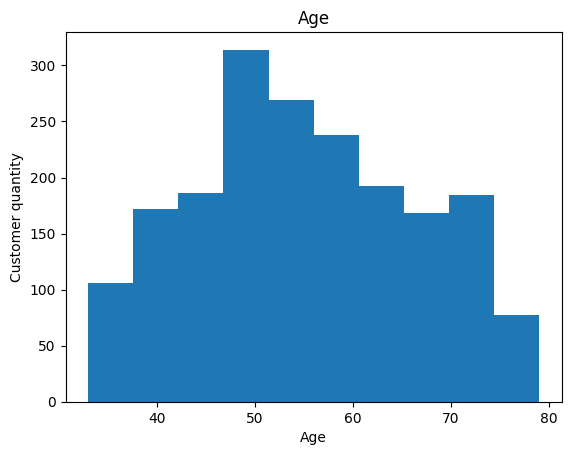

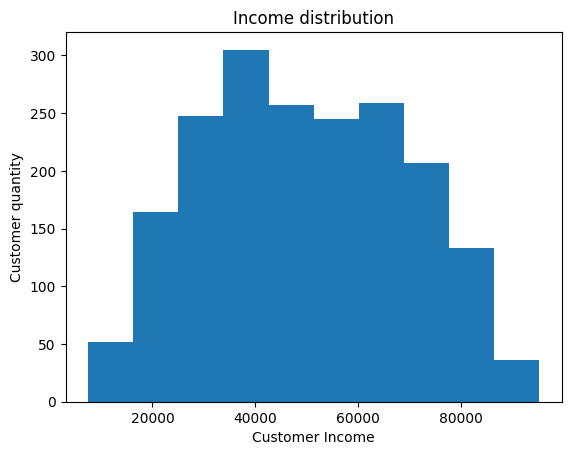

In [21]:
plt.hist(data['Age'], bins = 10)
plt.title('Age')
plt.ylabel('Customer quantity')
plt.xlabel('Age')
plt.show()

plt.hist(data['Income'], bins = 10)
plt.title('Income distribution')
plt.ylabel('Customer quantity')
plt.xlabel('Customer Income')
plt.show()

We can see that outliers are gone and data is more normaly distributed.<br>
As we have cleaned our data, lets see what we can get from it. Firstly lets look into Purchase channels, like web, catalogue or store.

Text(0.5, 0, 'Customer purchase channel')

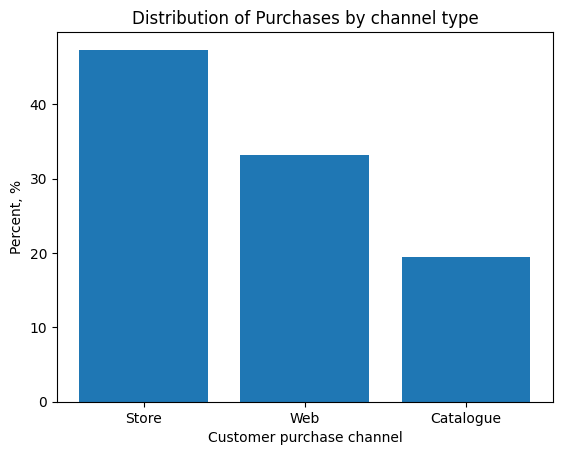

In [22]:
sorted = data[['Web', 'Catalogue', 'Store']].sum().sort_values(ascending = False)
title = 'Distribution of Purchases by channel type'
plt.bar(sorted.index.values, (sorted.values/sorted.sum()) * 100)
plt.title(title)
plt.ylabel('Percent, %')
plt.xlabel('Customer purchase channel')

Seems that most of the purchases are made in store more than 40 %, and least is made using orders from catalogues, about 20%<br>
Web purchases landed in the middle, more than 30 %<br>
Now we can try to find out who is using which channel. I will be using Correalation matrix.

In [23]:
correlation_matrix = data[['Age', 'Education', 'Single', 'Together', 'Married',
                           'Divorced', 'Widow','Income', 'Kidhome', 'Teenhome',
                           'Customer_tenure', 'Recency', 'Complain','Web',
                           'Catalogue', 'Store', 'NumWebVisitsMonth']].corr()

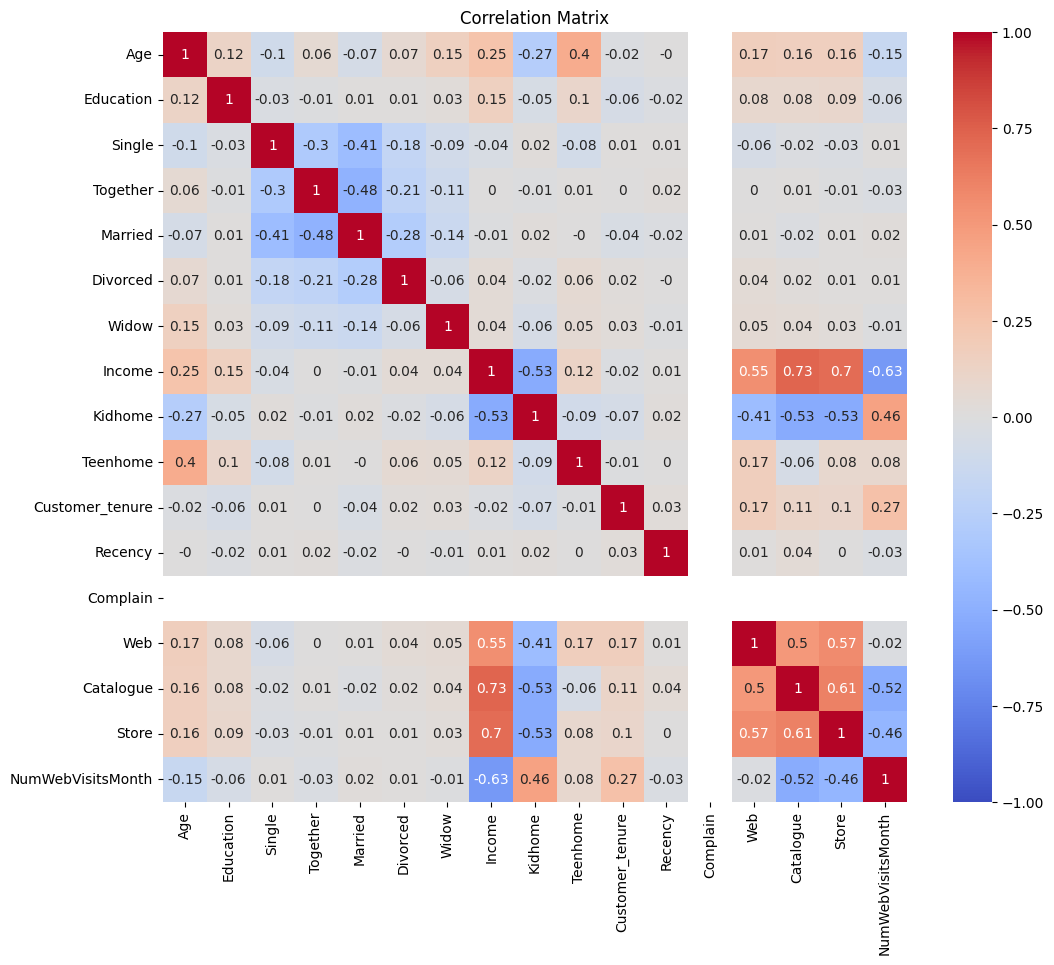

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(round(correlation_matrix, 2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Interesting. Complain doesn't have any values. it might be empty.

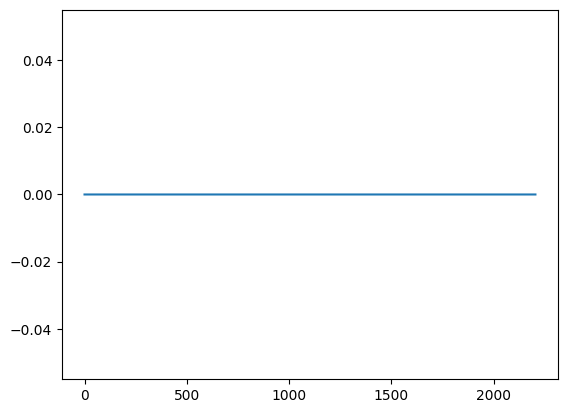

In [25]:
plt.plot(data['Complain'])

Yes, all values seems to be 0, so I will drop this column, also there are many values with little to no correalation<br>
so, for easier read purpose I will remove them from the matrix

In [26]:
data = data.drop('Complain', axis = 1)

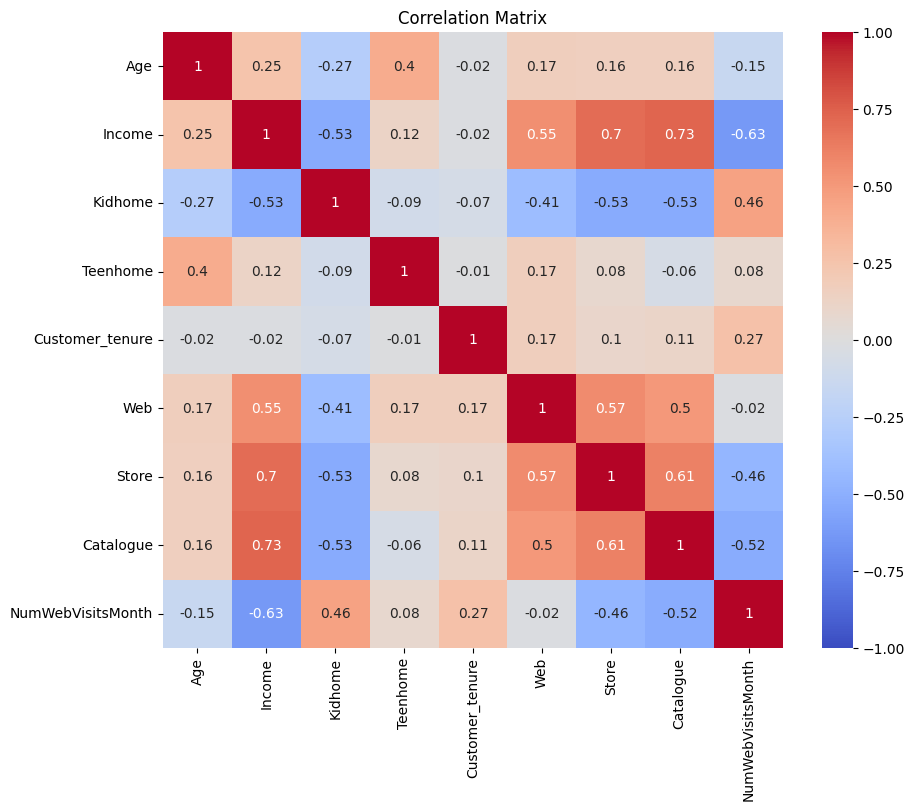

In [27]:
correlation_matrix = data[['Age','Income', 'Kidhome', 'Teenhome',
                           'Customer_tenure', 'Web', 'Store', "Catalogue",'NumWebVisitsMonth']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(round(correlation_matrix, 2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Age is slightly correlated with all three channels, which means there is no choice among them but it is correlated with more purchases overall.<br>
It might be because age is positively correlated with income, and income is strongly correlated with purchases.<br>
The strongest correlations are with Income, Kidhome, Teenhome, Customer_tenure, Number of WEb visits.<br>
Income is positevly correlated with all channels and is negatively correlated with web visits per month. Which means that more wealthy people consume more, and people with low income tend to use web more.<br>
Interestingly more web visits are not correlated with more web purchasis. What suggests that customer is just checking, probably looking for good deals or maybe did not find what were looking for?<br>
Kidhome is negatively correlated with purchases and income. But positively correlated to web visits. It makes sense, because there is probably stay at home parent, who doesnt work, and prefers shopping<br>
from home because is taking care of the kid. As having a kid is negatively correalated to income it suggest that web is just checked to hunt better deals.<br>
Teenhome is slightly positively correlated with web visits and purchases, and negatively correlated to catalog purchases. Which might show that teenagers might influence the parents and that younger people<br>
prefer web purchasing.<br>
Customer tenure positively correlates to web purchases and web visits. It seems that new customers are more likely to go to store or to use catalogs. It is difficult to say what is the reason for it, I could speculate<br>
that it is influenced by the nature how they found out about the shop, for example from catalogues, so they more prone to use them at first till they find out about web services. Or just convenience of the location of the store.<br>
Other speculation could be that people are cautious about newly found shop and prefer buying at the store at first, actualy trying/inspecting the product and tend to use web shop when they develope trust.<br>

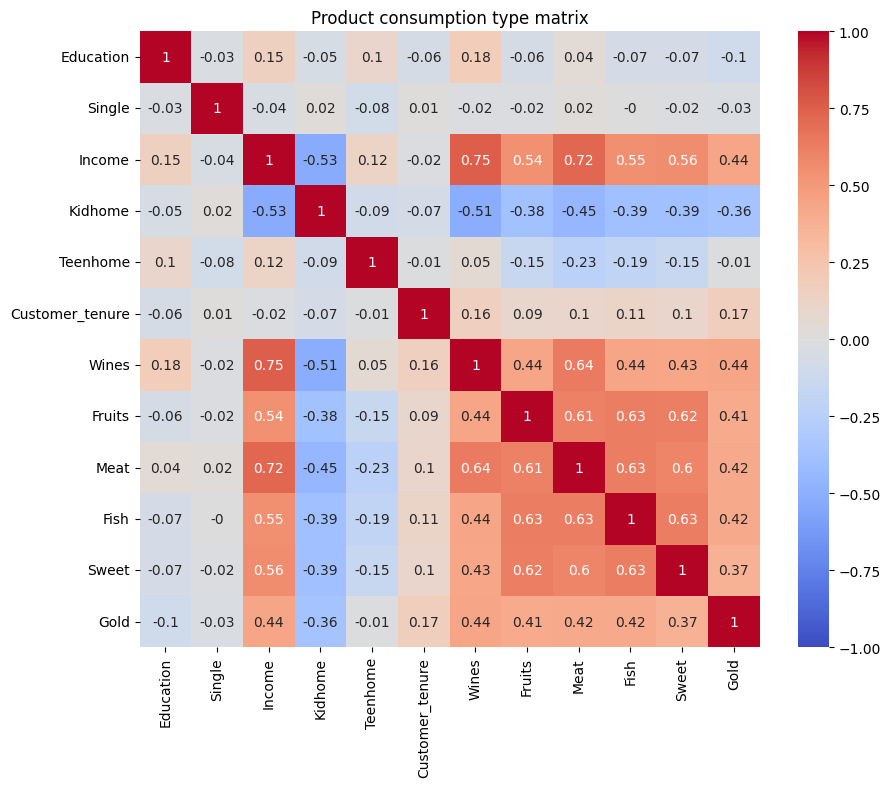

In [28]:
# lets remove irrelevant features
correlation_matrix = data[['Education', 'Single','Income', 'Kidhome', 'Teenhome', 'Customer_tenure', 'Wines',
                           'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(round(correlation_matrix, 2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Product consumption type matrix')
plt.show()

Correlation matrix above supposed to reveal type of products different customers choose.<br>
We can see that higher income is more correlated to meat and whine consuming, also these two products tend to correlate, so meat and whine might be purchased together.<br>
But we don't have data of the customer carts to confirm that.<br>
Also we can see that people with kids are less likely to purchase wine and more likely to purchase fruits.<br>
People with teenagers seems to tend to sweet products and fruits and least likely to consume meat.<br>

Now lets see who are more likely to participate in advertising campaigns.<br>
We don't have information about separate marketing campaigns, so we just sum up how many in total customer was involved.<br>

In [29]:
data['Accepted_campaigns'] = data[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis = 1)

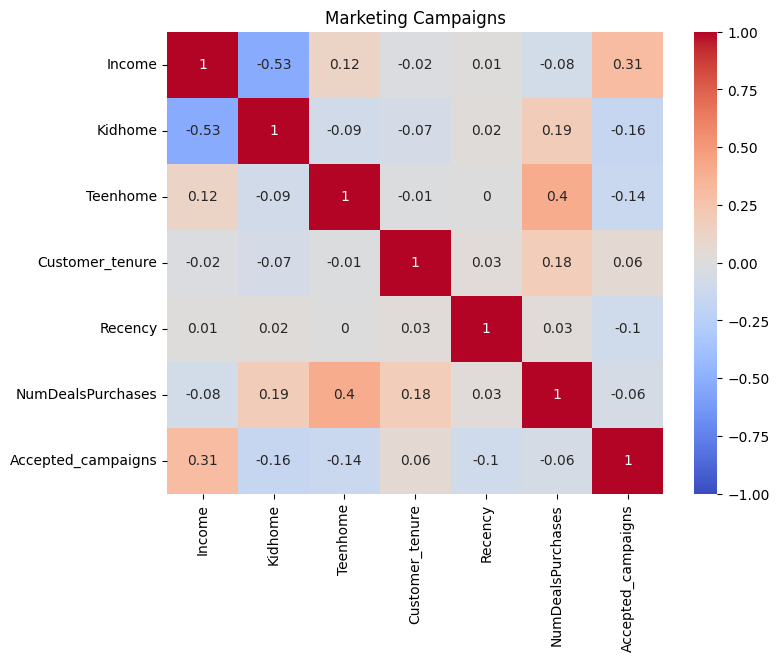

In [30]:
correlation_matrix = data[['Income', 'Kidhome', 'Teenhome', 'Customer_tenure', 'Recency', 
                           'NumDealsPurchases', 'Accepted_campaigns']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(round(correlation_matrix, 2), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Marketing Campaigns')
plt.show()

As previously most important features are income, and children at home.<br>
We can see that people with kids and teenagers are more likely to pursue discounts.<br>
People with higher income tend to participate in promotion campaigns.<br>
People with children seem to be opposite and participate less. Would be interesting to see why is that, but we don't have any info about those promotions.<br>
I could speculate that either they do not contain products of interest, or that to participate you have to physicaly attend some places and people with children<br>
have limited ability to do so. But, again, it is just speculation.<br>

In [31]:
stopper

NameError: name 'stopper' is not defined

Now we will build regression model to evaluate customer consumption.<br>
Regression model will show an average amount for every product category and we will be able to see<br>
who falls short and who consumes more.

In [36]:
def linear_regression_training(scaled_data, target):
    X_train, X_validate, y_train, y_validate = train_test_split(scaled_data, target, test_size=0.2)

    lr_wines = lr()
    lr_wines.fit(X_train, y_train)

    training_prediction = lr_wines.predict(X_train)
    validation_prediction = lr_wines.predict(X_validate)

    training_mae = mean_absolute_error(training_prediction, y_train)
    validation_mae = mean_absolute_error(validation_prediction, y_validate)

    print('Training MAE:', round(training_mae, 2), training_mae/max(training_prediction))
    print('Validation MAE:', round(validation_mae))

    return {'training_prediction':training_prediction, 'validation_prediction':validation_prediction, 'training_mae':training_mae, 'validation_mae':validation_mae, 'model':lr_wines}


In [37]:
data_scaler = StandardScaler()
scaled_data = data_scaler.fit_transform(data[['Age', 'Education', 'Single', 'Together', 'Married', 'Divorced', 'Widow','Income', 'Kidhome', 'Teenhome', 'Customer_tenure', 'Recency', 
                           'NumDealsPurchases', 'Accepted_campaigns', 'Store', 'Web', 'Catalogue']])
# poly = PolynomialFeatures(2)
# scaled_data = poly.fit_transform(scaled_data)


target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(data[['Wines','Fruits', 'Meat', 'Fish', 'Sweet', 'Gold']])

purchase_prediction = {}
n = 0
for i in ['Wines','Fruits', 'Meat', 'Fish', 'Sweet', 'Gold']:
    print(i)
    purchase_prediction[i] = linear_regression_training(scaled_data, scaled_target[:,n])
    n += 1

Wines
Training MAE: 0.36 0.14049518760809324
Validation MAE: 0
Fruits
Training MAE: 0.5 0.2749628369330738
Validation MAE: 1
Meat
Training MAE: 0.36 0.15242731496005862
Validation MAE: 0
Fish
Training MAE: 0.5 0.26015688525908665
Validation MAE: 0
Sweet
Training MAE: 0.49 0.26408143257055106
Validation MAE: 1
Gold
Training MAE: 0.55 0.3723856893851053
Validation MAE: 1


In [38]:
regularization = l1_l2(l1=0.01, l2=0.01)

dnn = {}
products = ['Wines','Fruits', 'Meat', 'Fish', 'Sweet', 'Gold']
for i in range(6):
    model = Sequential([
    Input((17,)),
    Dense(32, activation = 'tanh', kernel_regularizer = regularization),
    Dense(32, activation = 'tanh', kernel_regularizer = regularization),
    Dense(32, activation = 'tanh', kernel_regularizer = regularization),
    Dense(1),
    ])



    optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=250,
        min_delta=0.001,
        restore_best_weights=True 
    )
    model.fit(scaled_data, scaled_target[:,i], validation_split=0.2, epochs = 1500, batch_size = 2000, callbacks=[early_stopping])
    dnn[products[i]] = model

Epoch 1/1500
1/1 [==============================] - 1s 1s/step - loss: 6.5371 - mae: 1.0234 - val_loss: 6.3836 - val_mae: 0.9788
Epoch 2/1500
1/1 [==============================] - 0s 26ms/step - loss: 6.3762 - mae: 0.9670 - val_loss: 6.2320 - val_mae: 0.9234
Epoch 3/1500
1/1 [==============================] - 0s 31ms/step - loss: 6.2289 - mae: 0.9140 - val_loss: 6.0942 - val_mae: 0.8716
Epoch 4/1500
1/1 [==============================] - 0s 29ms/step - loss: 6.0942 - mae: 0.8640 - val_loss: 5.9689 - val_mae: 0.8226
Epoch 5/1500
1/1 [==============================] - 0s 26ms/step - loss: 5.9721 - mae: 0.8174 - val_loss: 5.8556 - val_mae: 0.7768
Epoch 6/1500
1/1 [==============================] - 0s 26ms/step - loss: 5.8616 - mae: 0.7740 - val_loss: 5.7535 - val_mae: 0.7340
Epoch 7/1500
1/1 [==============================] - 0s 25ms/step - loss: 5.7620 - mae: 0.7345 - val_loss: 5.6615 - val_mae: 0.6944
Epoch 8/1500
1/1 [==============================] - 0s 30ms/step - loss: 5.6720 - mae

In [39]:
X_train, X_validate, y_train, y_validate = train_test_split(scaled_data, scaled_target, test_size=0.2, shuffle=False)

Wines
12/12 [==============================] - 0s 1ms/step
Fruits
12/12 [==============================] - 0s 1ms/step
Meat
12/12 [==============================] - 0s 1ms/step
Fish
12/12 [==============================] - 0s 1ms/step
Sweet
12/12 [==============================] - 0s 1ms/step
Gold
12/12 [==============================] - 0s 1ms/step
[0.27, 0.45, 0.27, 0.43, 0.42, 0.52]
[0.34, 0.5, 0.37, 0.49, 0.46, 0.54]


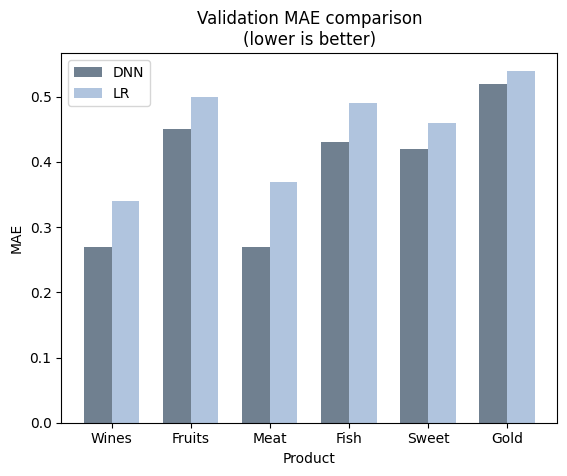

In [40]:
mae_dnn = []
mae_lr = []
for i, key in zip(range(6), products):
    print(key)
    pred = dnn[key].predict(X_validate)
    mae_dnn.append(round(mean_absolute_error(pred, y_validate[:,i]),2))
    mae_lr.append(round(mean_absolute_error(purchase_prediction[key]['model'].predict(X_validate), y_validate[:,i]),2))
print(mae_dnn)
print(mae_lr)

position = np.arange(len(mae_dnn))
width = 0.35
multiplier = 0
mae = [mae_dnn, mae_lr]
label = ['DNN', 'LR']
colors = ['slategrey', 'lightsteelblue']
for i in range(2):
    plt.bar(position + width*multiplier, mae[i], width = width, label = label[i], color = colors[i])
    multiplier += 1

plt.xticks(position + width/2, products)
plt.title('Validation MAE comparison\n(lower is better)')
plt.xlabel('Product')
plt.ylabel('MAE')
plt.legend()

I built two models - based on linear regression (LR) and deep neural network (DNN).<br>
As we can see above DNN performed better in all product categories.<br>
Lets inspect the results visualy.

60/60 [==============================] - 0s 1ms/step


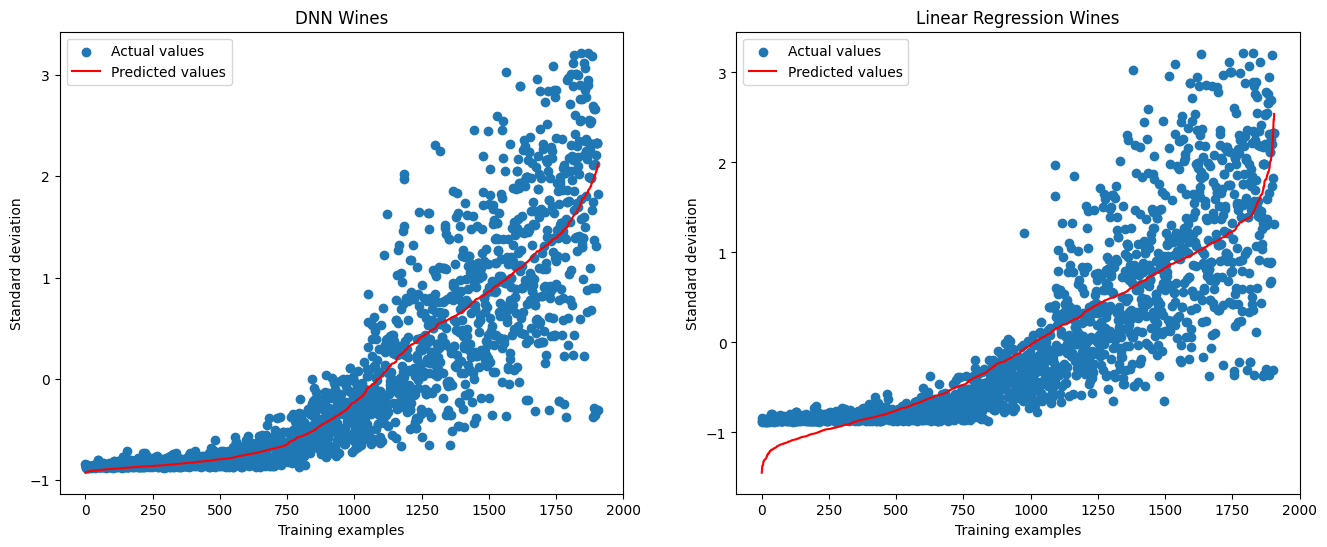

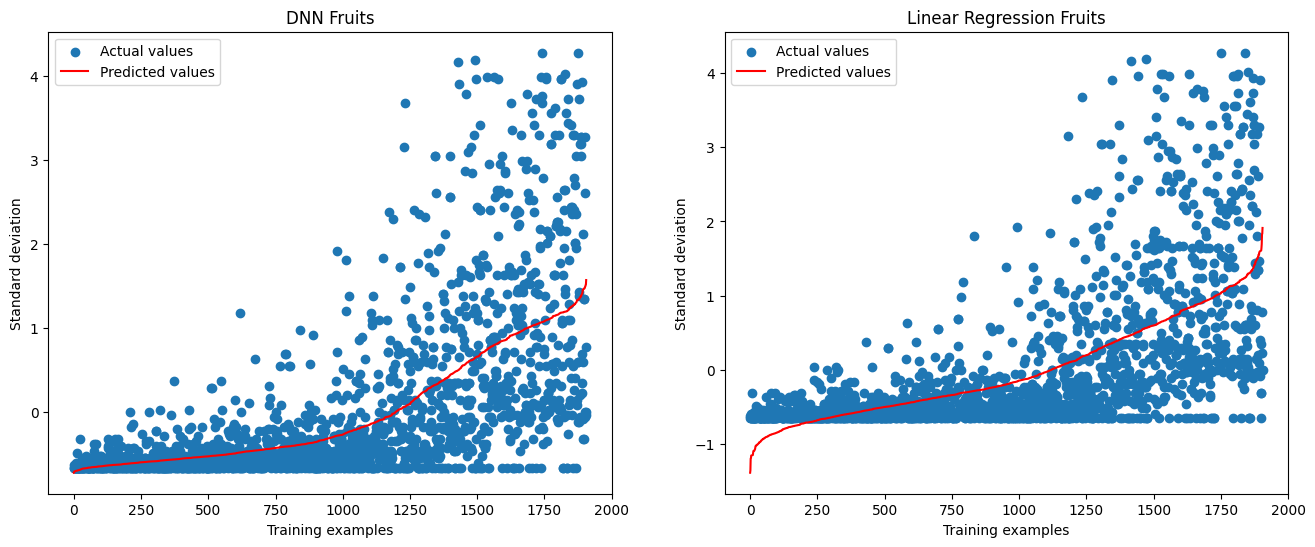

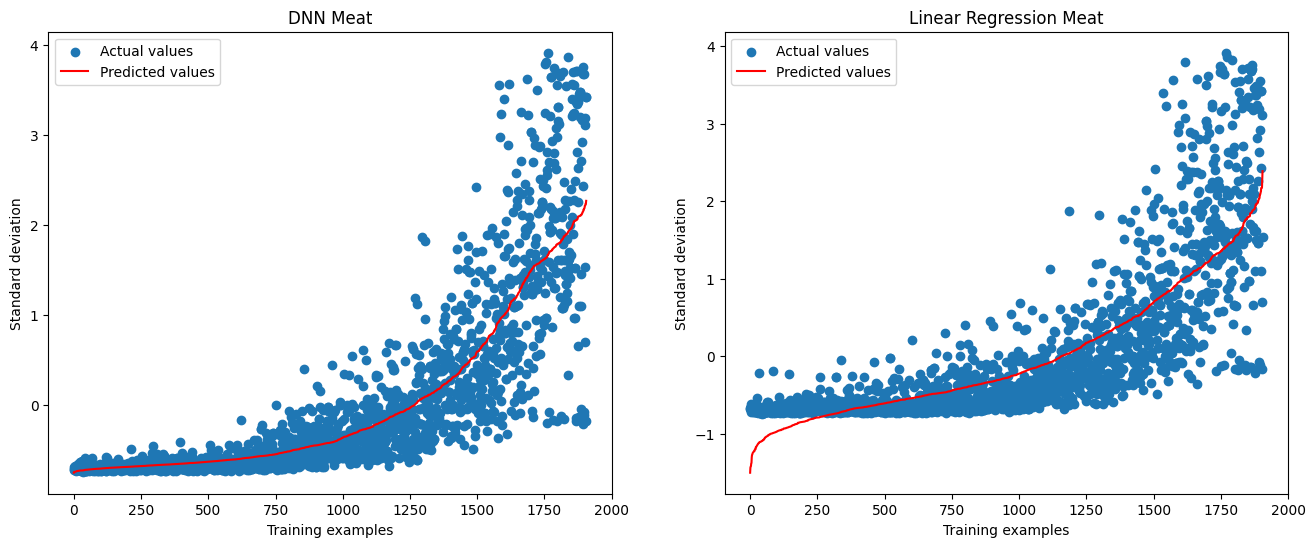

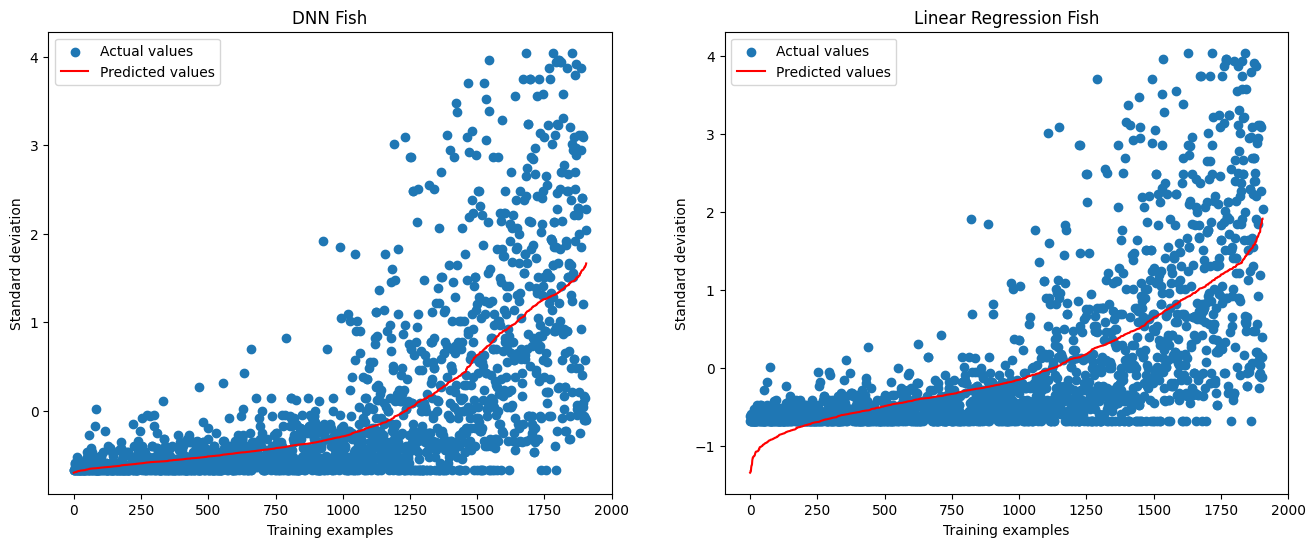

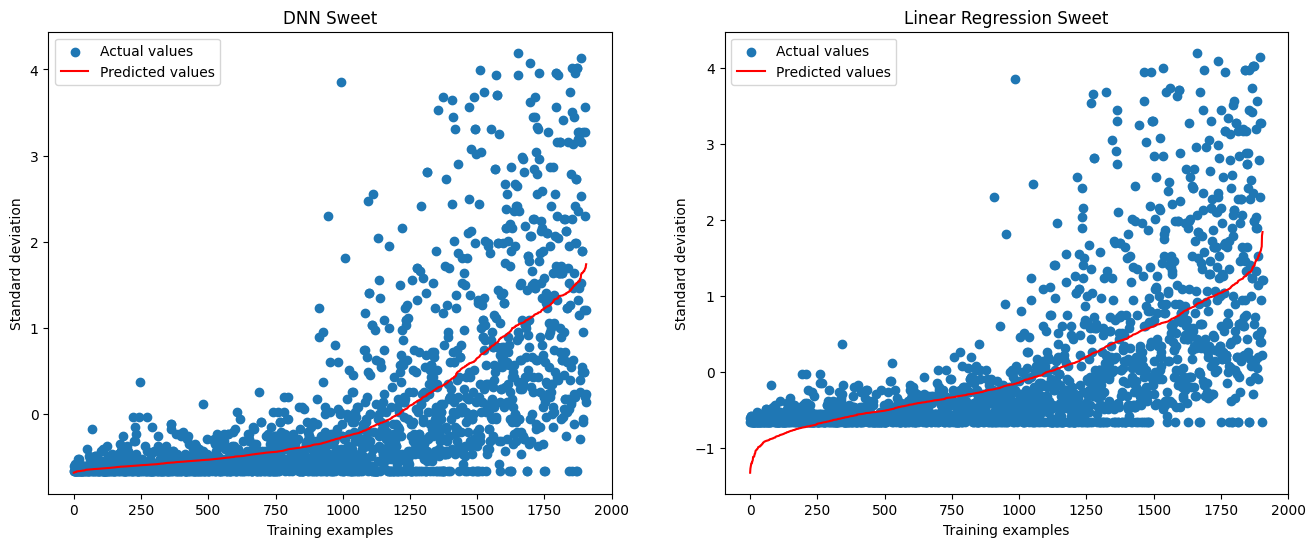

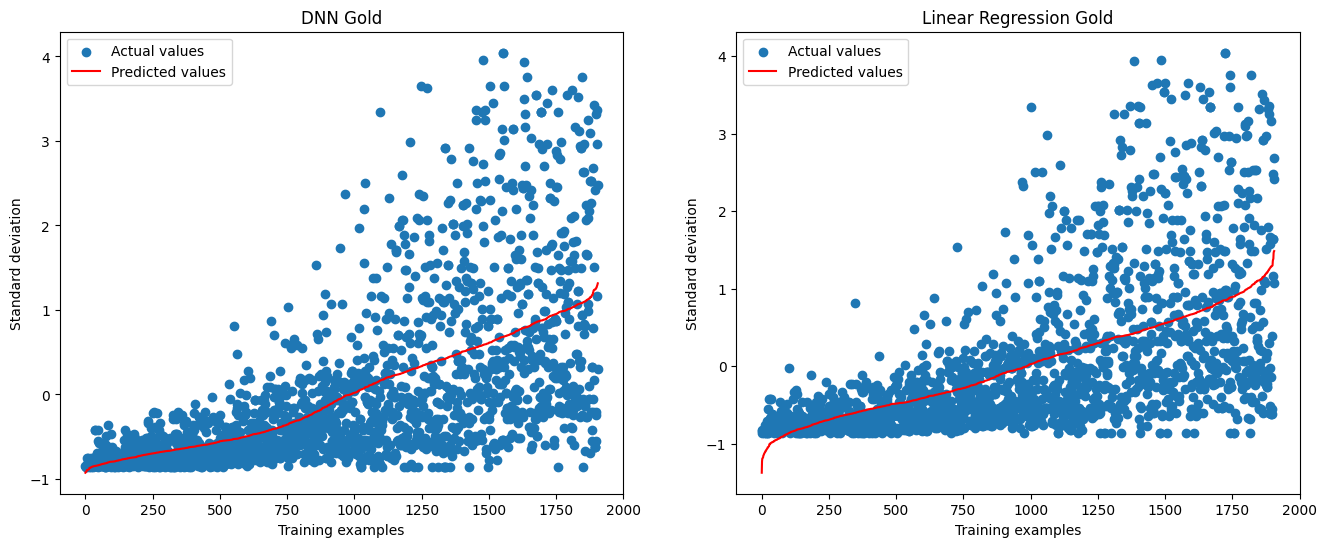

In [41]:
for i in range(len(products)):
    temp_lr = pd.DataFrame()
    temp_dnn = pd.DataFrame()
    temp_dnn['predicted'] = dnn[products[i]].predict(scaled_data).flatten()
    temp_lr['predicted'] = purchase_prediction[products[i]]['model'].predict(scaled_data)
    temp_dnn['actual'] = scaled_target[:,i]
    temp_lr['actual'] = scaled_target[:,i]
    temp_dnn = temp_dnn.sort_values(['predicted'], ascending = True).reset_index()
    temp_lr = temp_lr.sort_values(['predicted'], ascending = True).reset_index()

    f, ax = plt.subplots(1,2, figsize = (16, 6))
    ax[0].scatter(range(0,len(temp_dnn)), temp_dnn['actual'])
    ax[0].plot(range(0,len(temp_dnn)), temp_dnn['predicted'], color = 'red')
    ax[0].set_xlabel('Training examples')
    ax[0].set_ylabel('Standard deviation')
    ax[0].set_title(f'DNN {products[i]}')
    ax[0].legend(['Actual values', 'Predicted values'])

    ax[1].scatter(range(0,len(temp_lr)), temp_lr['actual'])
    ax[1].plot(range(0,len(temp_lr)), temp_lr['predicted'], color = 'red')
    ax[1].set_xlabel('Training examples')
    ax[1].set_ylabel('Standard deviation')
    ax[1].set_title(f'Linear Regression {products[i]}')
    ax[1].legend(['Actual values', 'Predicted values'])

DNN seems to better fit extreme values (lowest, highest) and fits the shape very well.<br>
So, I will use DNN model from now on, and we could try some parameter tuning to find best solutions<br>
for each product individually. I will use randomized search to look for better models.

We have 6 models, doing randomized search might take a while.<br>
I built optimization.py for randomized search which will be using multiprocessing to increase speed.<br>
Parameters will be saved to 'optimized_parameters.joblib' file.<br>

In [ ]:
#saving scaled data for training
joblib.dump(scaled_data, 'scaled_data.sav')
joblib.dump(scaled_target, 'scaled_target.sav')

['scaled_target.sav']

In [118]:
# loading optimized parameters
optimized = joblib.load('optimized_parameters.joblib')

In [77]:
# model building function according to found parameters
def dnn_model(layers = 3, neurons = 32, activation = 'tanh', learning_rate = 0.02, regularization = 0.01, input_shape = (17,)):
    reg = l1_l2(l1=regularization, l2=regularization)
    model = Sequential()
    model.add(Input(input_shape))
    for l in range(layers):
        model.add(Dense(neurons, activation = activation, kernel_regularizer = reg)),
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss = 'mean_squared_error')
    return model

In [119]:
# building new models
optimized_models = {}
for i in range(6):
    optimized_models[products[i]] = dnn_model(layers = optimized[i][products[i]]['layers'], neurons = optimized[i][products[i]]['layers'], activation = optimized[i][products[i]]['activation'],
                                              learning_rate=optimized[i][products[i]]['learning_rate'], regularization=optimized[i][products[i]]['regularization'])

In [120]:
# training
for i in range(6):
    optimized_models[products[i]].fit(scaled_data, scaled_target[:,i], validation_split = 0.2, epochs = 1500, batch_size = 2000, callbacks = [early_stopping])

Epoch 1/1500
1/1 [==============================] - 0s 297ms/step - loss: 3.1172 - val_loss: 2.9001
Epoch 2/1500
1/1 [==============================] - 0s 32ms/step - loss: 2.9632 - val_loss: 2.7639
Epoch 3/1500
1/1 [==============================] - 0s 35ms/step - loss: 2.8183 - val_loss: 2.6361
Epoch 4/1500
1/1 [==============================] - 0s 25ms/step - loss: 2.6820 - val_loss: 2.5176
Epoch 5/1500
1/1 [==============================] - 0s 29ms/step - loss: 2.5544 - val_loss: 2.4060
Epoch 6/1500
1/1 [==============================] - 0s 25ms/step - loss: 2.4338 - val_loss: 2.3017
Epoch 7/1500
1/1 [==============================] - 0s 25ms/step - loss: 2.3210 - val_loss: 2.2053
Epoch 8/1500
1/1 [==============================] - 0s 25ms/step - loss: 2.2156 - val_loss: 2.1162
Epoch 9/1500
1/1 [==============================] - 0s 31ms/step - loss: 2.1180 - val_loss: 2.0321
Epoch 10/1500
1/1 [==============================] - 0s 31ms/step - loss: 2.0260 - val_loss: 1.9554
Epoch 11

Wines
12/12 [==============================] - 0s 1ms/step
Fruits
12/12 [==============================] - 0s 1ms/step
Meat
12/12 [==============================] - 0s 1ms/step
Fish
12/12 [==============================] - 0s 1ms/step
Sweet
12/12 [==============================] - 0s 1ms/step
Gold
12/12 [==============================] - 0s 2ms/step


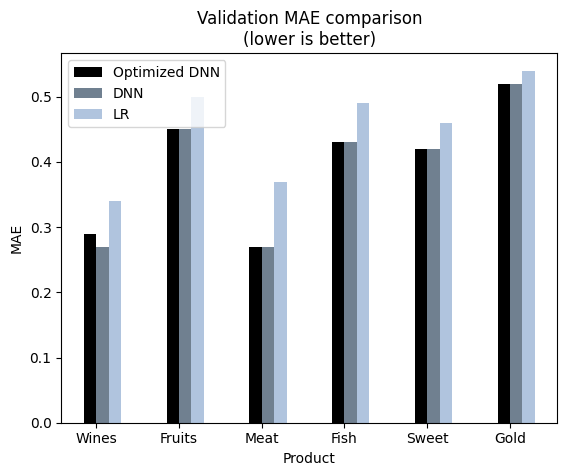

In [121]:
mae_optimized = []
mae_dnn = []
mae_lr = []
for i, key in zip(range(6), products):
    print(key)
    pred = dnn[key].predict(X_validate)
    mae_dnn.append(round(mean_absolute_error(pred, y_validate[:,i]),2))
    mae_lr.append(round(mean_absolute_error(purchase_prediction[key]['model'].predict(X_validate), y_validate[:,i]),2))
    mae_optimized.append(round(mean_absolute_error(optimized_models[key].predict(X_validate), y_validate[:,i]),2))

position = np.arange(len(mae_dnn))
width = 0.15
multiplier = 0
mae = [mae_optimized, mae_dnn, mae_lr]
label = ['Optimized DNN', 'DNN', 'LR']
colors = ['black', 'slategrey', 'lightsteelblue']
for i in range(3):
    plt.bar(position + width*multiplier, mae[i], width = width, label = label[i], color = colors[i])
    multiplier += 1

plt.xticks(position + width/2, products)
plt.title('Validation MAE comparison\n(lower is better)')
plt.xlabel('Product')
plt.ylabel('MAE')
plt.legend()

Seems like we have little to no improvement. So we can leave our primary model.<br>
<br>
Now that models are prepared we can use them for targeting. Oposed to most popular methods, like clustering<br>
and segmentation to devide customers and look for their distinct features, I will just use income and predicted<br>
consumption to rank all the customers individually by their potential. We have observed that income is highly correalated<br>
with more purchases. So we will look for customers who consume low but have high income.

In [81]:
income_scaler = StandardScaler()
scaled_income = income_scaler.fit_transform(data[['Income']])

consumption_scaler = StandardScaler()
scaled_consumption = consumption_scaler.fit_transform(data[['Wines','Fruits', 'Meat', 'Fish', 'Sweet', 'Gold']])


In [82]:
scaled_consumption = pd.DataFrame(scaled_consumption, columns = ['Wines','Fruits', 'Meat', 'Fish', 'Sweet', 'Gold'])
scaled_consumption['ID'] = data['ID'].values
scaled_income = pd.DataFrame(scaled_income, columns = ['Income'])
scaled_income['ID'] = data['ID'].values

I will be using distance between consumption and income to measure how much potential there is.<br>
For example, if the customer's income is way bigger and has positive standard deviaton of 2 but the consumption deviation is -2<br>
indicating lower consumption than usual, we will have distance of (2 - (-2)) = 4, indicating quite high potential.<br>
If customer has high income, for example as previous 2 std, but it also consumes more than usual for example 1 std,<br>
than we will have less distance (2 - 1) = 1, indicating that potential is lower. Also it could indicate overconsuming customers<br>
for example, if their income is not that high for example -1 but they consume more 1 std. Distance will be <br>
(-1-1) = -2, indicating that they consume way more than usual and has low potential.

In [83]:
target = pd.DataFrame()
for i in scaled_consumption.columns:
    if i != 'ID':
        target[f'{i}'] = scaled_income['Income'] -  scaled_consumption[i]
target.index = scaled_consumption['ID'].values


Now we can sort by desired product category and set the threshold to filter customer ids.

In [84]:
target[target['Wines'] > 0]['Wines'].sort_values(ascending = False)

2535     2.325347
7872     2.209750
4828     2.197349
6906     2.151623
7828     2.105394
           ...   
10260    0.001809
2262     0.001809
8652     0.000212
4939     0.000212
2782     0.000144
Name: Wines, Length: 941, dtype: float64

Now I will use our deep neural network (dnn) to determine what consumption we could expect and compare it to actual customer purchases.<br>
The ones who are consuming less than predicted might be potential targets.

In [89]:
pred_consumption = pd.DataFrame()
for i, key in zip(range(6), products):
    pred = dnn[key].predict(scaled_data)
    pred_consumption[key] = pred.flatten()

60/60 [==============================] - 0s 911us/step


Now we can calculate distance between predicted and actual.

In [122]:
target2 = pd.DataFrame()
for i in products:
    target2[i] = pred_consumption[i] -  scaled_consumption[i]
target2.index = scaled_consumption['ID'].values
target2['Wines'][target2['Wines'] > 0].sort_values(ascending=False)

7872     2.430863
2535     2.372890
6906     2.360861
10473    2.339814
10446    2.268117
           ...   
1951     0.000933
2634     0.000615
8969     0.000597
89       0.000409
2098     0.000302
Name: Wines, Length: 906, dtype: float64

Now we have two lists of same customers - those who have high potential by income and those who consume less than average.<br>
I will filter customers who fall in both groups.

In [125]:
customers_std = set(target[target['Wines'] > 0]['Wines'].sort_values(ascending = False).index.values)
customers_dnn = set(target2[target2['Wines'] > 0]['Wines'].sort_values(ascending = False).index.values)

In [126]:
same_customers = customers_std.intersection(customers_dnn)
print('Total customers by std:', len(customers_std))
print('Total customers by actual value:', len(customers_dnn))
print('Same customers', len(same_customers)/len(customers_std))

Total customers by std: 941
Total customers by actual value: 906
Same customers 0.7236981934112646


We can see that about 72% customers intersect. That means they have high income and consuming less than average.<br>
We can calculate how potentialy we could expect from them to increase in consumption assuming they can reach the average level.

In [143]:
pred_consumption_amount = consumption_scaler.inverse_transform(pred_consumption)
difference = pred_consumption_amount - data[products]
difference.set_index(data['ID'], inplace=True)
difference.loc[np.array(same_customers)]['Wines'].sum()

73666.54843378067

Assuming that customers can reach current average level of consumption, we could expect an increase of income over two years by 73666.

<font size="5">Conclusion</font><br>

What we learned about the customers:<br>
1. More wealthy people consume more in general. They are more likely to shop at the stores or using catalogues. They are more likely to buy wines and meat and participate in marketing campaigns.<br>
2. People with kids consume less and are more likely to shop at the web. They also are more likely to use 'deals'.<br>

Suggestions:<br>
1. Meat and wines usually are bought together, so they could be placed near each other at the store.
2. As meat and wines are consumed more by wealthy people, who use store and catalogues, campaigns should focus on these channels to reach the customers.<br>
3. Customers with kids at home are more using internet and looking for deals, so deals on the web should focus more on the products like fruits, fish.<br>
4. In general more purchases are made in physical store, so it is important to maintain customer experience there.